In [194]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime as dt
from pandas.plotting import scatter_matrix
import yfinance as yf

%matplotlib inline

In [195]:
conda install "jupyterlab>=3" "ipywidgets>=7.6"


Note: you may need to restart the kernel to use updated packages.


In [196]:
def mcmc(start_price, horizon, average, stdev):
  price=np.zeros(horizon)
  price[0]=start_price
  trend=np.zeros(horizon)
  shock=np.zeros(horizon)
  delta=1/horizon

  for x in range(1,horizon):
    shock[x]=random.gauss(average, stdev)
    trend[x]=average*delta
    price[x]=price[x-1]+(price[x-1]*(trend[x]+shock[x]))

  return price

In [197]:
startdate=dt(2010,1,1)
enddate=dt(2021,12,31)

df=pdr.get_data_yahoo('ATVI', start=startdate, end=enddate)['Adj Close']
df.head()

Date
2010-01-04    10.077828
2010-01-05    10.095665
2010-01-06    10.042156
2010-01-07     9.801357
2010-01-08     9.721092
Name: Adj Close, dtype: float64

In [198]:
df_ret=np.log(df/df.shift(1))
df_ret.head()


Date
2010-01-04         NaN
2010-01-05    0.001768
2010-01-06   -0.005314
2010-01-07   -0.024271
2010-01-08   -0.008223
Name: Adj Close, dtype: float64

In [199]:
start=df[-1]
start

60.619998931884766

In [200]:
mu=df_ret.mean()
mu

0.0005988942090658133

In [201]:
sigma=df_ret.std()
sigma

0.019528152538589066

In [202]:
horizon=50

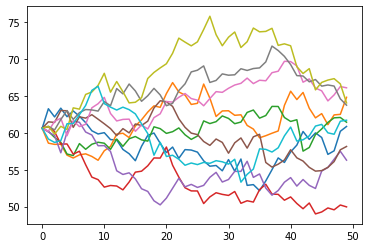

In [203]:
for run in range(10):
  plt.plot(mcmc(start, horizon, mu, sigma))

In [204]:
runs=10000
simulation=np.zeros(runs)

for run in range(runs):
  simulation [run]=mcmc(start, horizon, mu, sigma)[-1]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

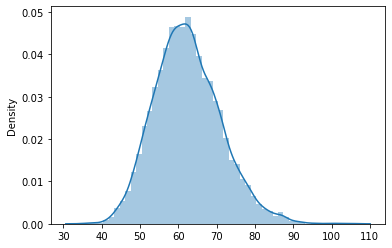

In [205]:
sns.distplot(simulation)

In [206]:
np.percentile(simulation, 5)

49.26400437723057

In [207]:
start-np.percentile(simulation, 5)

11.355994554654195

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



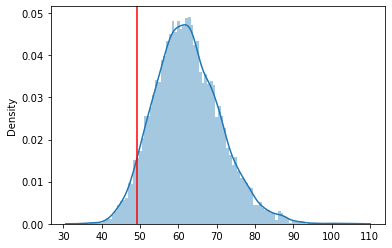

In [208]:
sns.distplot(simulation,bins=100)
plt.axvline(x=np.percentile(simulation, 5), color='r')

In [209]:
discount_factor=np.exp(-mu*(1/horizon))
K=start
premium=discount_factor * np.average(np.maximum(0,simulation[:]-K))
premium

4.340119246364876

In [210]:
### Dynamic Visualisation

In [211]:
import plotly.graph_objects as go
import plotly.express as px

In [212]:
!pip install --upgrade plotly

In [213]:
tickers=['ATVI', 'NTDOY', 'UBI.PA']
startdate=dt(2010,1,1)
enddate=dt(2020,12,31)

df=pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
df.head()

Symbols,ATVI,NTDOY,UBI.PA
Date,,,
2010-01-04,10.077829,30.900000,10.135
2010-01-05,10.095664,31.469999,10.540
2010-01-06,10.042154,33.150002,11.080
2010-01-07,9.801356,34.220001,11.005
2010-01-08,9.721091,34.820000,10.970


In [214]:
df_y=df.resample('Y').last().pct_change().dropna()
df_y=df_y*100
df_y.head()

Symbols,ATVI,NTDOY,UBI.PA
Date,,,
2011-12-31,0.536588,-53.371870,-35.443198
2012-12-31,-12.554411,-21.428571,51.808159
2013-12-31,70.096804,25.319307,30.955412
2014-12-31,14.098420,-22.362113,47.519459
2015-12-31,94.075578,33.281857,78.865810


In [215]:
final=df_y.unstack().reset_index()
final=final.rename(columns={0:'Performance'})
final.head()

,Symbols,Date,Performance
0,ATVI,2011-12-31,0.536588
1,ATVI,2012-12-31,-12.554411
2,ATVI,2013-12-31,70.096804
3,ATVI,2014-12-31,14.098420
4,ATVI,2015-12-31,94.075578


In [216]:
final=final.replace(to_replace=['ATVI', 'NTDOY', 'UBI.PA'],
                    value=['USA', 'JPN', 'FRA'])
final.head()

,Symbols,Date,Performance
0,USA,2011-12-31,0.536588
1,USA,2012-12-31,-12.554411
2,USA,2013-12-31,70.096804
3,USA,2014-12-31,14.098420
4,USA,2015-12-31,94.075578


In [217]:
final['Date']=final['Date'].dt.strftime("%Y")
final.head()

,Symbols,Date,Performance
0,USA,2011,0.536588
1,USA,2012,-12.554411
2,USA,2013,70.096804
3,USA,2014,14.098420
4,USA,2015,94.075578


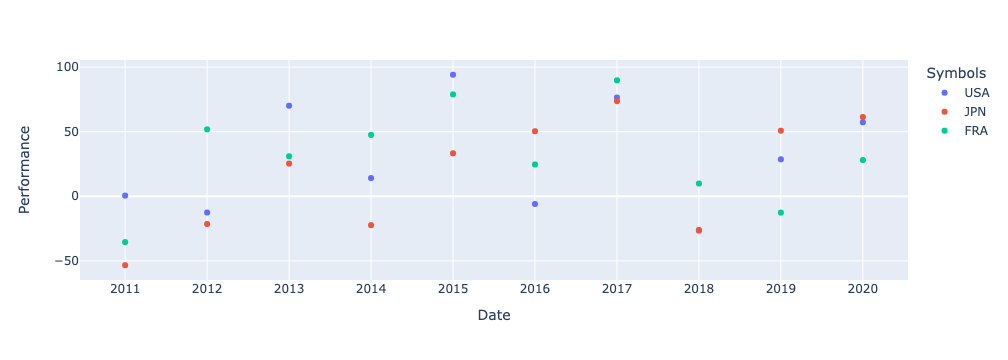

In [218]:
px.scatter(final, x="Date", y="Performance", color="Symbols")

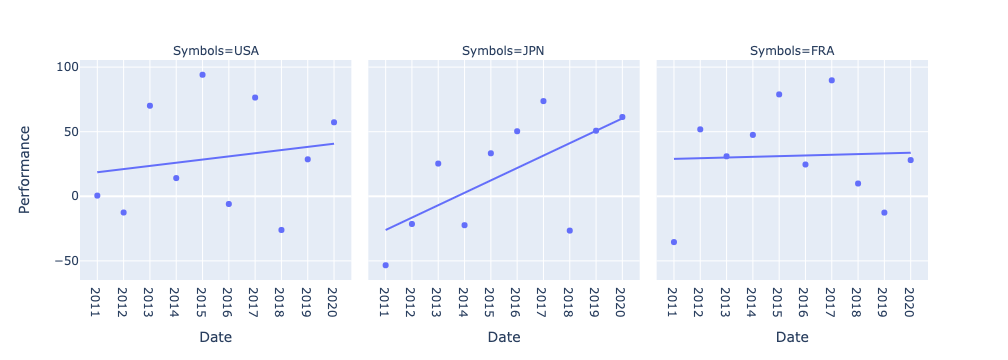

In [219]:
px.scatter(final, x="Date", y="Performance", facet_col="Symbols", trendline="ols")

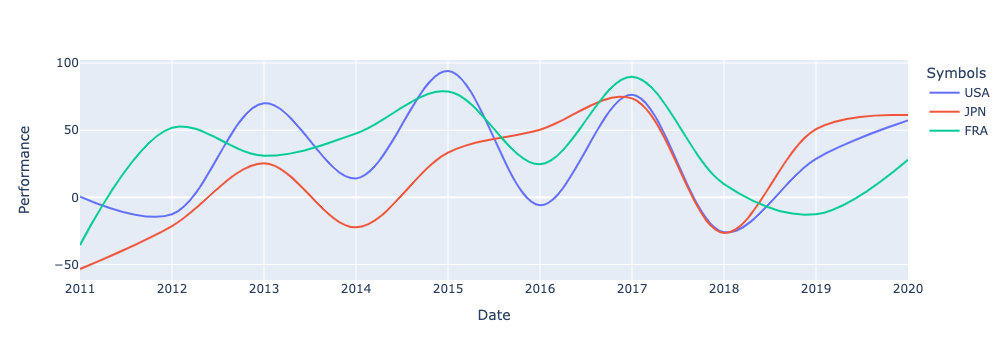

In [273]:
fig= px.line(final, x="Date", y="Performance", color="Symbols", line_shape="spline")
fig.write_html("performance.html")
fig.show()

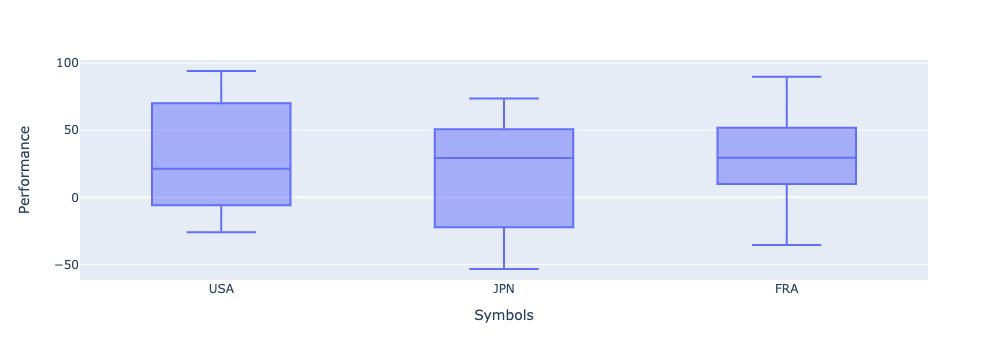

In [269]:
fig= px.box(final, x="Symbols", y="Performance")
fig.write_html("Box.html")
fig.show()

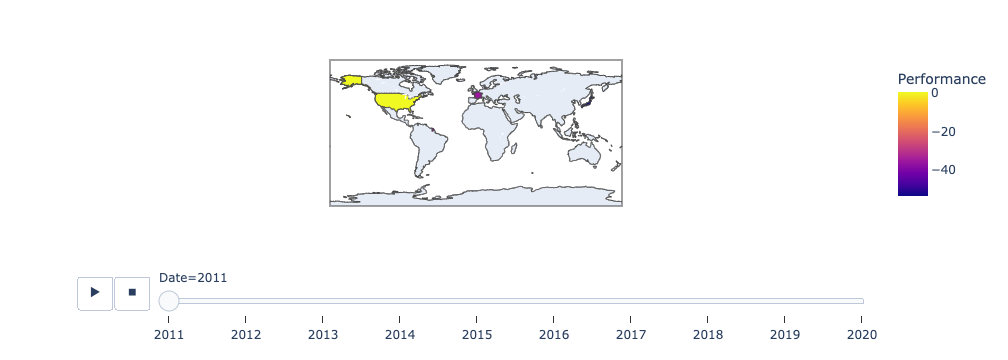

In [271]:
fig = px.choropleth(final, locations="Symbols", color="Performance", animation_frame="Date")
fig.write_html("chrono.html")
fig.show()

In [223]:
final["Sign"]=np.sign(final["Performance"])
final["Absolute"]=np.absolute(final["Performance"])
final.head()

,Symbols,Date,Performance,Sign,Absolute
0,USA,2011,0.536588,1.0,0.536588
1,USA,2012,-12.554411,-1.0,12.554411
2,USA,2013,70.096804,1.0,70.096804
3,USA,2014,14.098420,1.0,14.098420
4,USA,2015,94.075578,1.0,94.075578


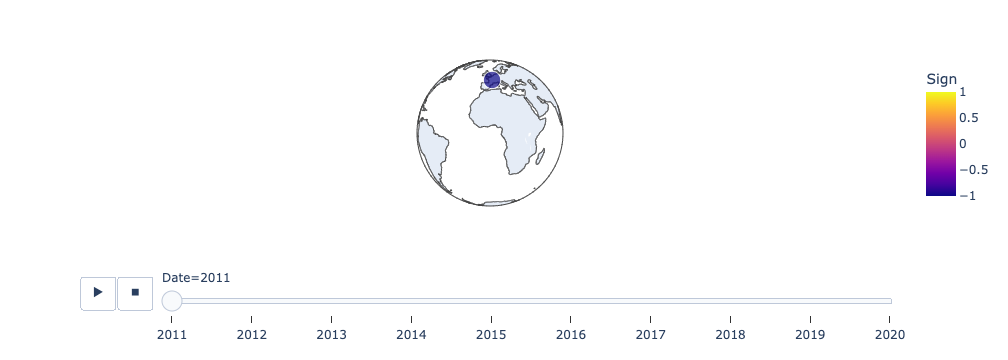

In [272]:
fig = px.scatter_geo(final,locations='Symbols', size='Absolute',color='Sign', animation_frame='Date', projection='orthographic')
fig.write_html("Geo.html")
fig.show()

In [265]:
pwd

'/Users/marobassem/Directory'

In [225]:
start = "2010-01-01"
end = '2021-12-31'
ATVI = yf.download('ATVI',start,end)
NTDOY = yf.download('NTDOY',start,end)
UBI = yf.download('UBI.PA',start,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


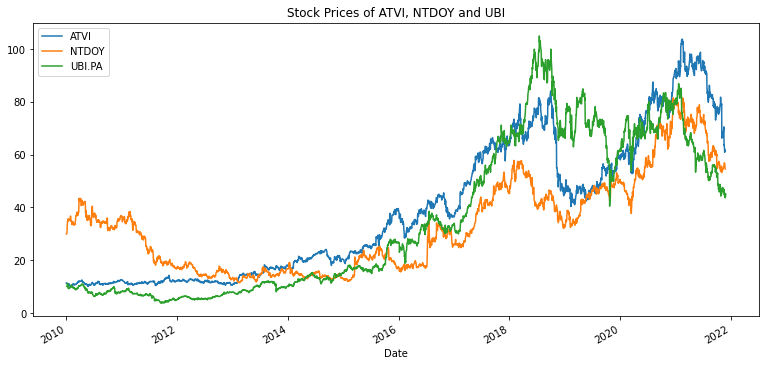

In [275]:
#Stock Prices
ATVI['Open'].plot(label = 'ATVI', figsize = (13,6))
NTDOY['Open'].plot(label = "NTDOY")
UBI['Open'].plot(label = 'UBI.PA')
plt.title('Stock Prices of ATVI, NTDOY and UBI')
plt.legend()

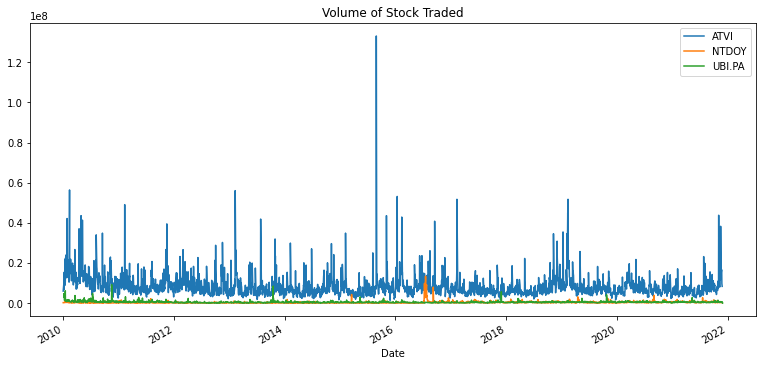

In [246]:
#Volume Traded
ATVI['Volume'].plot(label = 'ATVI', figsize = (13,6))
NTDOY['Volume'].plot(label = "NTDOY")
UBI['Volume'].plot(label = 'UBI.PA')
plt.title('Volume of Stock Traded')
plt.legend()

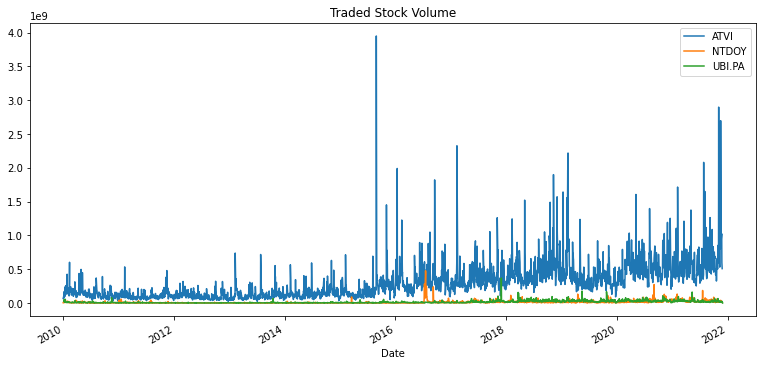

In [248]:
#Market Cap
ATVI['MarketCap'] = ATVI['Open'] * ATVI['Volume']
NTDOY['MarketCap'] = NTDOY['Open'] * NTDOY['Volume']
UBI['MarketCap'] = UBI['Open'] * UBI['Volume']

ATVI['MarketCap'].plot(label = 'ATVI', figsize = (13,6))
NTDOY['MarketCap'].plot(label = 'NTDOY')
UBI['MarketCap'].plot(label = 'UBI.PA')
plt.title('Traded Stock Volume')
plt.legend()

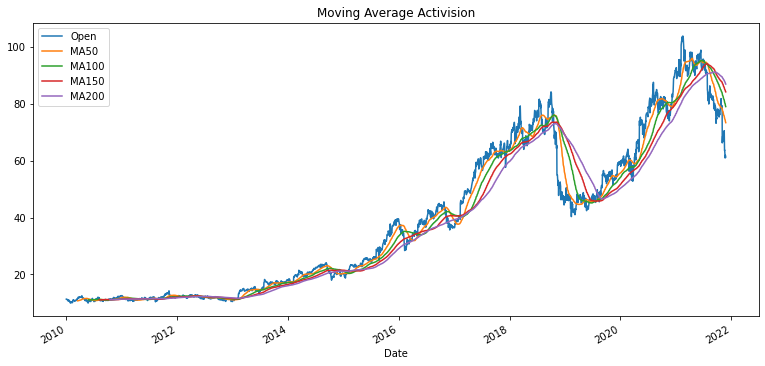

In [249]:
ATVI['MA50'] = ATVI['Open'].rolling(50).mean()
ATVI['MA100'] = ATVI['Open'].rolling(100).mean()
ATVI['MA150'] = ATVI['Open'].rolling(150).mean()
ATVI['MA200'] = ATVI['Open'].rolling(200).mean()
ATVI['Open'].plot(figsize = (13,6))

ATVI['MA50'].plot()
ATVI['MA100'].plot()
ATVI['MA150'].plot()
ATVI['MA200'].plot()
plt.title('Moving Average Activision')
plt.legend()

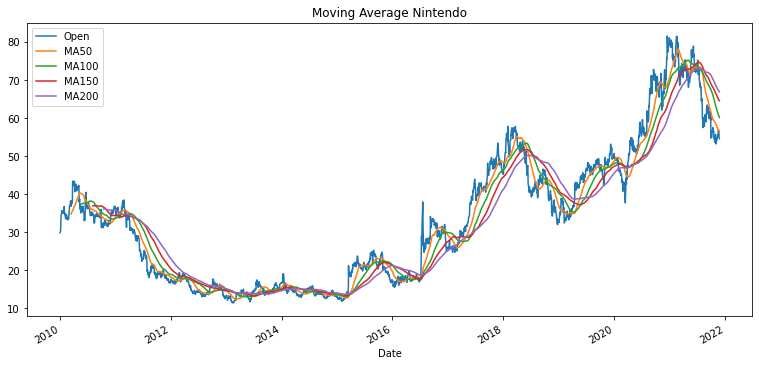

In [250]:
NTDOY['MA50'] = NTDOY['Open'].rolling(50).mean()
NTDOY['MA100'] = NTDOY['Open'].rolling(100).mean()
NTDOY['MA150'] = NTDOY['Open'].rolling(150).mean()
NTDOY['MA200'] = NTDOY['Open'].rolling(200).mean()
NTDOY['Open'].plot(figsize = (13,6))

NTDOY['MA50'].plot()
NTDOY['MA100'].plot()
NTDOY['MA150'].plot()
NTDOY['MA200'].plot()
plt.title('Moving Average Nintendo')
plt.legend()

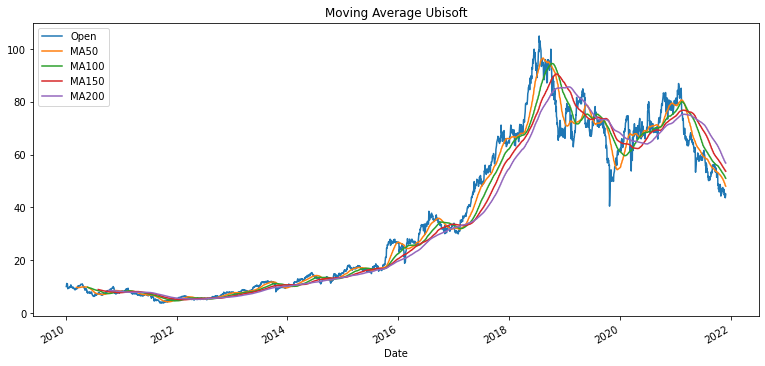

In [251]:
UBI['MA50'] = UBI['Open'].rolling(50).mean()
UBI['MA100'] = UBI['Open'].rolling(100).mean()
UBI['MA150'] = UBI['Open'].rolling(150).mean()
UBI['MA200'] = UBI['Open'].rolling(200).mean()
UBI['Open'].plot(figsize = (13,6))

UBI['MA50'].plot()
UBI['MA100'].plot()
UBI['MA150'].plot()
UBI['MA200'].plot()
plt.title('Moving Average Ubisoft')
plt.legend()

array([[<AxesSubplot:xlabel='ATVI Open', ylabel='ATVI Open'>,
        <AxesSubplot:xlabel='NTDOY Open', ylabel='ATVI Open'>,
        <AxesSubplot:xlabel='UBI Open', ylabel='ATVI Open'>],
       [<AxesSubplot:xlabel='ATVI Open', ylabel='NTDOY Open'>,
        <AxesSubplot:xlabel='NTDOY Open', ylabel='NTDOY Open'>,
        <AxesSubplot:xlabel='UBI Open', ylabel='NTDOY Open'>],
       [<AxesSubplot:xlabel='ATVI Open', ylabel='UBI Open'>,
        <AxesSubplot:xlabel='NTDOY Open', ylabel='UBI Open'>,
        <AxesSubplot:xlabel='UBI Open', ylabel='UBI Open'>]], dtype=object)

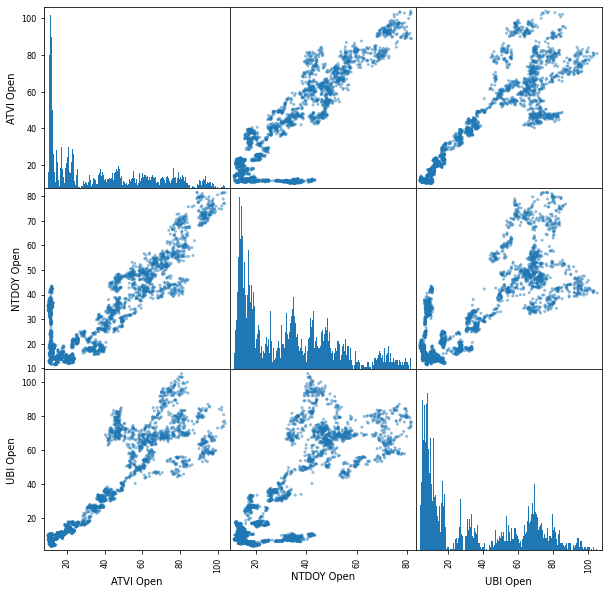

In [258]:
data = pd.concat([ATVI['Open'],NTDOY['Open'],UBI['Open']],axis = 1)
data.columns = ['ATVI Open','NTDOY Open','UBI Open']
scatter_matrix(data, figsize = (10,10), hist_kwds= {'bins':250})


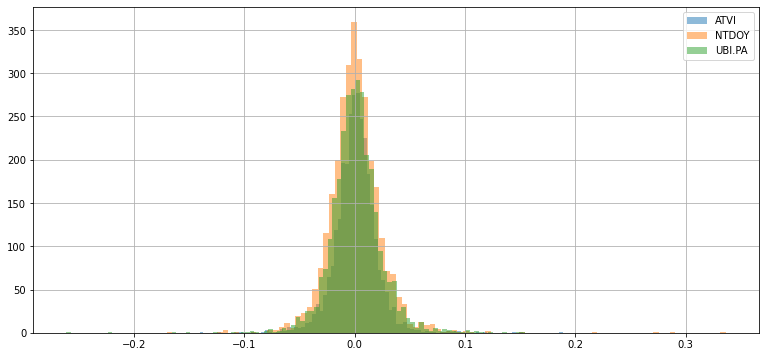

In [257]:
#Volatility
ATVI['return'] = (ATVI['Close']/ATVI['Close'].shift(1)) -1
NTDOY['return'] = (NTDOY['Close']/NTDOY['Close'].shift(1)) - 1
ATVI['return'].hist(bins = 100, label = 'ATVI', alpha = 0.5, figsize = (13,6))

NTDOY['return'].hist(bins = 100, label = 'NTDOY', alpha = 0.5)
plt.legend()
UBI['return'] = (UBI['Close']/UBI['Close'].shift(1)) - 1
UBI['return'].hist(bins = 100, label = 'UBI.PA', alpha = 0.5)
plt.legend()